## Data exploration

- fullVisitorId- A unique identifier for each customer of the Gstore.
- channelGrouping - The channel via which the user came to the store.
- customDimensions - ???
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- hits -  This section contains hits information.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).


In [19]:
import pandas as pd
import numpy as np
import json
from ast import literal_eval
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
j_col = ['device', 'geoNetwork', 'totals', 'trafficSource']

In [34]:
train_df = pd.read_csv('train_v2.csv', converters={column: json.loads for column in j_col},dtype={'fullVisitorId': 'str'}, nrows=100000)

In [12]:
train_df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{'browser': 'Firefox', 'browserVersion': 'not ...",3162355547410993243,"{'continent': 'Europe', 'subContinent': 'Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",8934116514970143966,"{'continent': 'Americas', 'subContinent': 'Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...",{'referralPath': '/a/google.com/transportation...,1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",7992466427990357681,"{'continent': 'Americas', 'subContinent': 'Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': '(direct)'...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",9075655783635761930,"{'continent': 'Asia', 'subContinent': 'Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': 'google', ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",6960673291025684308,"{'continent': 'Americas', 'subContinent': 'Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': 'google', ...",1508190552,1,1508190552


In [5]:
train_df.shape

(100000, 13)

In [6]:
train_df.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [44]:
hits_chunk = json_normalize(train_df['hits'].apply(lambda x: literal_eval(x)[0] if x != "[]" else literal_eval("{}")))

In [45]:
hits_chunk.head()

,appInfo.exitScreenName,appInfo.landingScreenName,appInfo.screenDepth,appInfo.screenName,contentGroup.contentGroup1,contentGroup.contentGroup2,contentGroup.contentGroup3,contentGroup.contentGroup4,contentGroup.contentGroup5,contentGroup.contentGroupUniqueViews1,...,promotionActionInfo.promoIsClick,promotionActionInfo.promoIsView,publisher_infos,referer,social.hasSocialSourceReferral,social.socialInteractionNetworkAction,social.socialNetwork,time,transaction.currencyCode,type
0,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,shop.googlemerchandisestore.com/google+redesig...,(not set),Bags,(not set),(not set),(not set),NaN,...,NaN,NaN,[],https://www.google.co.uk/search?q=water+bottle...,No,:,(not set),0,USD,PAGE
1,shop.googlemerchandisestore.com/asearch.html,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://sites.google.com/a/google.com/transpor...,No,:,(not set),0,NaN,PAGE
2,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.googlemerchandisestore.com/,No,:,(not set),0,NaN,PAGE
3,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.google.com.tr/,No,:,(not set),0,NaN,PAGE
4,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.google.com.mx/,No,:,(not set),0,NaN,PAGE


In [35]:
for column in j_col:
    column_as_df = json_normalize(train_df[column])
    column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
    train_df = train_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

In [38]:
column_as_df = json_normalize(train_df['customDimensions'].apply(lambda x: literal_eval(x)[0] if x != "[]" else {'index': 'NaN', 'value': 'NaN'}))
column_as_df.columns = [f" {'customDimensions'}_{subcolumn}" for subcolumn in column_as_df.columns]
train_df = train_df.drop('customDimensions', axis=1).merge(column_as_df, right_index=True, left_index=True)

In [39]:
train_df.shape

(100000, 60)

In [46]:
train_df.head()

,channelGrouping,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_index,customDimensions_value
0,Organic Search,20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,...,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google,4,EMEA
1,Referral,20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,...,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,4,North America
2,Direct,20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,...,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),4,North America
3,Organic Search,20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,...,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,EMEA
4,Organic Search,20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,...,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,Central America


In [22]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_browserSize', 'device_browserVersion',
       'device_deviceCategory', 'device_flashVersion', 'device_isMobile',
       'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_networkLocation',
       'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_sessionQualityDim', 'to

In [47]:
train_df.totals_transactionRevenue.fillna(0,inplace=True)

In [48]:
train_df.totals_transactionRevenue.value_counts()

0            99003
17590000        22
33590000        22
13590000        17
18990000        15
16990000        14
21990000        14
55990000        11
19990000        10
59990000        10
44790000         8
15190000         8
47990000         8
35180000         7
15990000         7
79990000         7
24990000         6
10390000         6
19190000         5
12990000         5
67180000         5
13290000         5
28780000         5
100000000        5
8790000          4
119990000        4
23990000         4
51990000         4
27180000         4
8990000          4
             ...  
30460000         1
26400000         1
134750000        1
127980000        1
37960000         1
139500000        1
31950000         1
90460000         1
80260000         1
728200000        1
147100000        1
23490000         1
279500000        1
137340000        1
116780000        1
76020000         1
103360000        1
263700000        1
200660000        1
74430000         1
37970000         1
86380000    

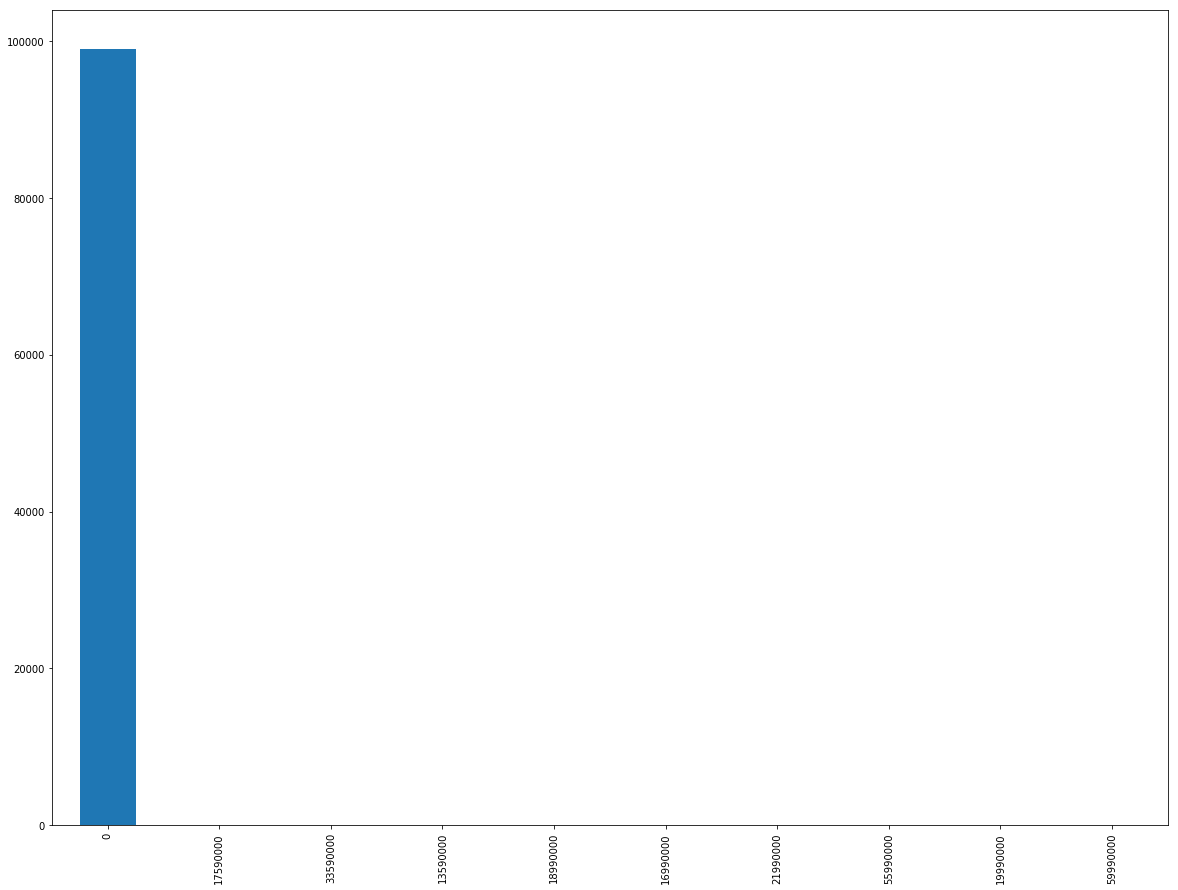

In [50]:
train_df.totals_transactionRevenue.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

In [23]:
train_df.device_browser.value_counts(dropna=False)

Chrome                      68272
Safari                      18609
Firefox                      3641
Android Webview              2357
Internet Explorer            2070
Edge                         1176
Samsung Internet              914
Opera Mini                    884
Safari (in-app)               744
Opera                         521
UC Browser                    328
YaBrowser                     153
Amazon Silk                    97
Coc Coc                        66
Android Browser                49
Mozilla Compatible Agent       32
BlackBerry                     17
Nintendo Browser               15
MRCHROME                       12
Puffin                         11
Maxthon                         9
Nokia Browser                   8
DESKTOP                         2
Browser                         2
Seznam                          1
LYF_LS_4002_12                  1
SeaMonkey                       1
ThumbSniper                     1
Mozilla                         1
IE with Chrome

In [24]:
train_df.device_deviceCategory.value_counts(dropna=False)

desktop    68920
mobile     27574
tablet      3506
Name: device_deviceCategory, dtype: int64

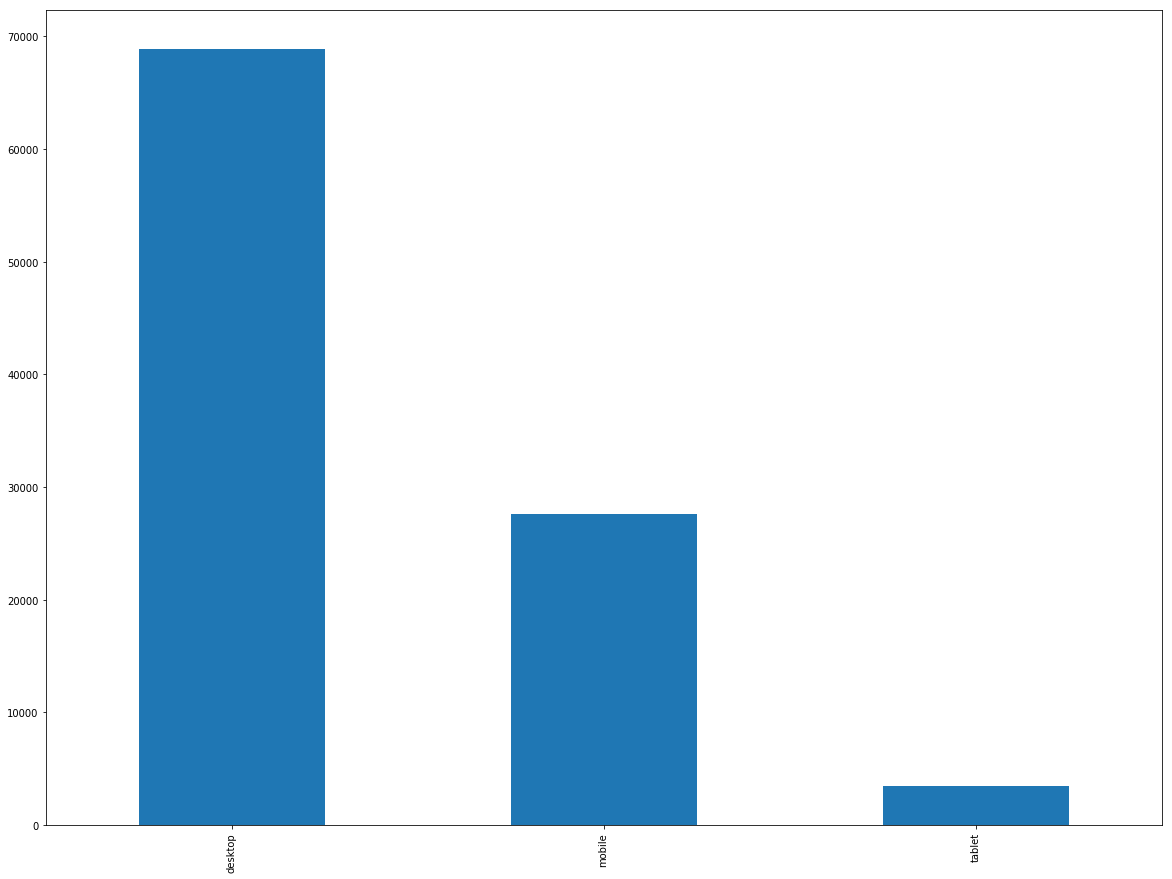

In [7]:
train_df.device_deviceCategory.value_counts(dropna=False).plot.bar(figsize=(20,15))

In [25]:
train_df.device_screenColors.value_counts(dropna=False)

not available in demo dataset    100000
Name: device_screenColors, dtype: int64

In [26]:
train_df.geoNetwork_longitude.value_counts(dropna=False)

not available in demo dataset    100000
Name: geoNetwork_longitude, dtype: int64

In [27]:
train_df.geoNetwork_country.value_counts(dropna=False)

United States               40783
India                        6472
United Kingdom               4322
Canada                       3011
Vietnam                      2486
Germany                      2183
Brazil                       2176
Japan                        2048
Thailand                     1905
France                       1847
Turkey                       1746
Mexico                       1581
Taiwan                       1527
Netherlands                  1521
Australia                    1352
Spain                        1332
Italy                        1240
Indonesia                    1038
Russia                       1021
Poland                        928
Singapore                     870
Romania                       821
Philippines                   811
Malaysia                      714
South Korea                   682
Ireland                       643
Egypt                         641
Belgium                       609
Ukraine                       580
Argentina     

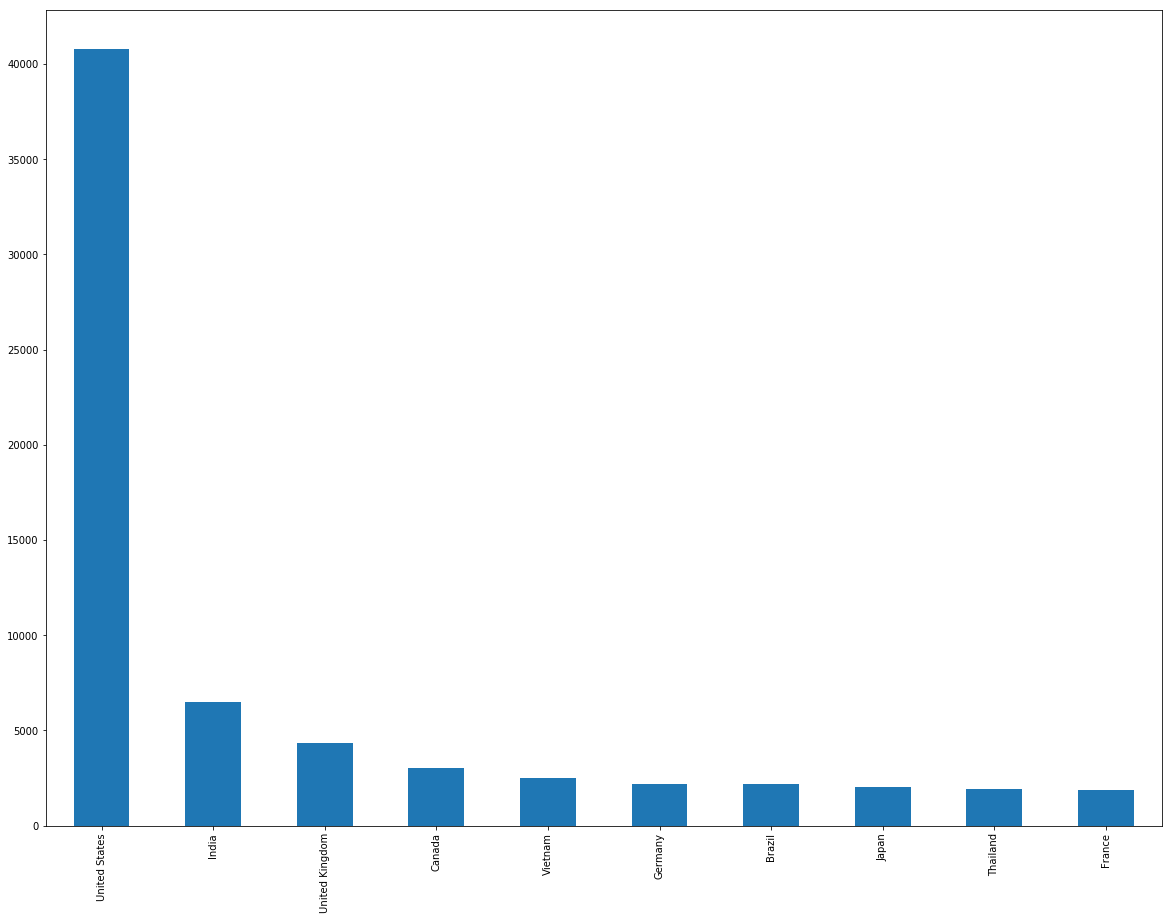

In [10]:
train_df.geoNetwork_country.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

In [28]:
train_df.geoNetwork_city.value_counts(dropna=False)

not available in demo dataset    54332
Mountain View                     4460
(not set)                         3863
New York                          2753
San Francisco                     2270
Sunnyvale                         1603
London                            1343
San Jose                          1189
Los Angeles                        942
Chicago                            840
Bangkok                            758
Ho Chi Minh City                   675
Bengaluru                          626
Toronto                            584
Seattle                            584
Istanbul                           575
Hyderabad                          542
Mumbai                             532
Sydney                             526
Hanoi                              520
Chennai                            516
Dublin                             491
Sao Paulo                          482
Paris                              455
Singapore                          447
Jakarta                  

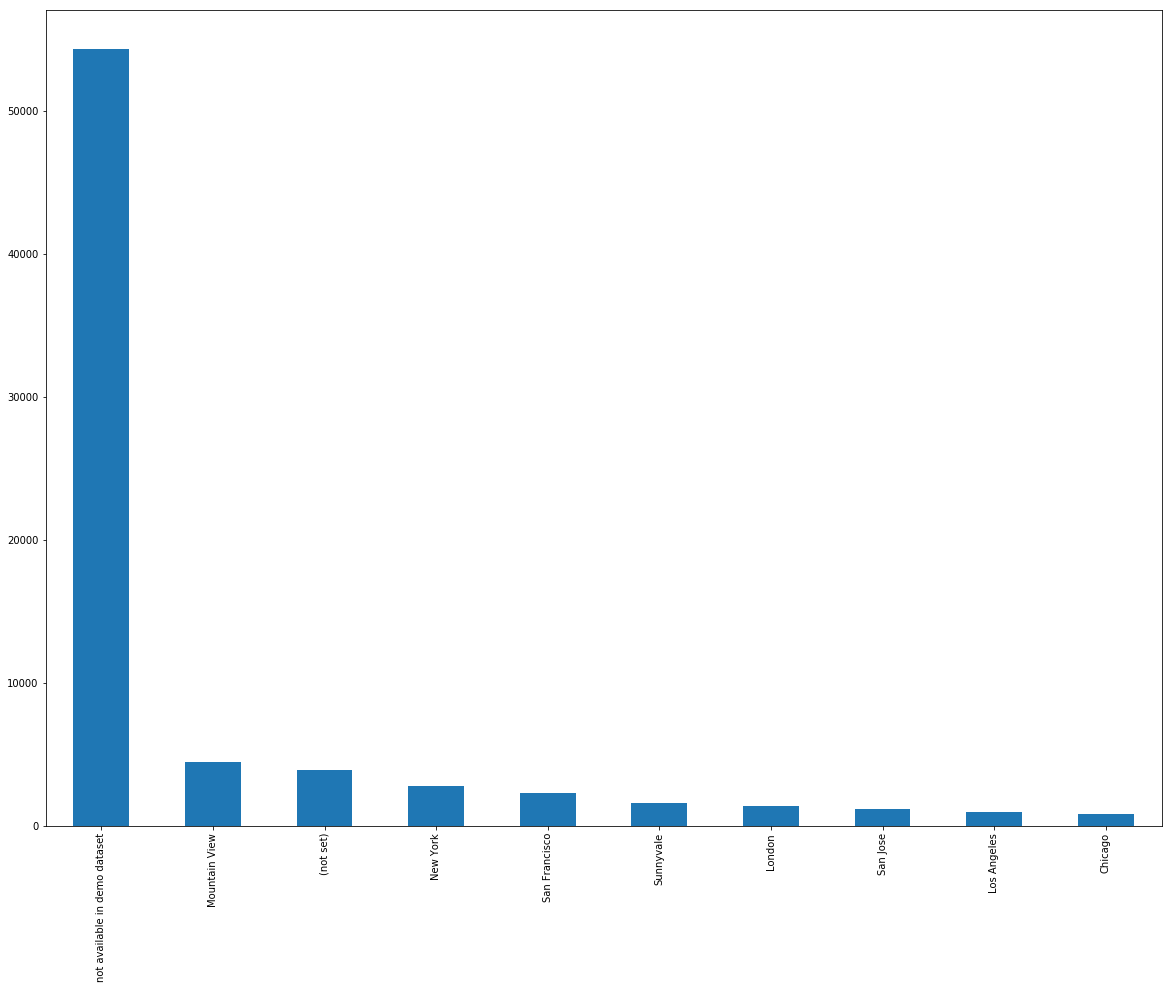

In [9]:
train_df.geoNetwork_city.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

In [29]:
train_df.trafficSource_adContent.value_counts(dropna=False)

NaN                                   96237
Google Merchandise Store               2276
Google Merchandise Collection           490
Placement Accessores 300 x 250          176
Display Ad created 3/11/14              118
Google Online Store                      96
Smart display ad - 8/17/2017             81
Full auto ad IMAGE ONLY                  52
Ad from 12/15/17                         51
Placement Drinkware 300x250              48
Official Google Merchandise              47
Ad from 12/13/16                         42
Display Ad created 3/11/15               33
Placement Accessories 336 x 280          25
{KeyWord:Google Merchandise}             23
Placement Accessories 160 x 600          17
{KeyWord:Google Brand Items}             15
Display Ad created 11/17/14              14
BQ                                       13
Placement Accessories 300 x 250          10
Swag with Google Logos                    9
Ad from 11/3/16                           9
{KeyWord:Looking for Google Bags

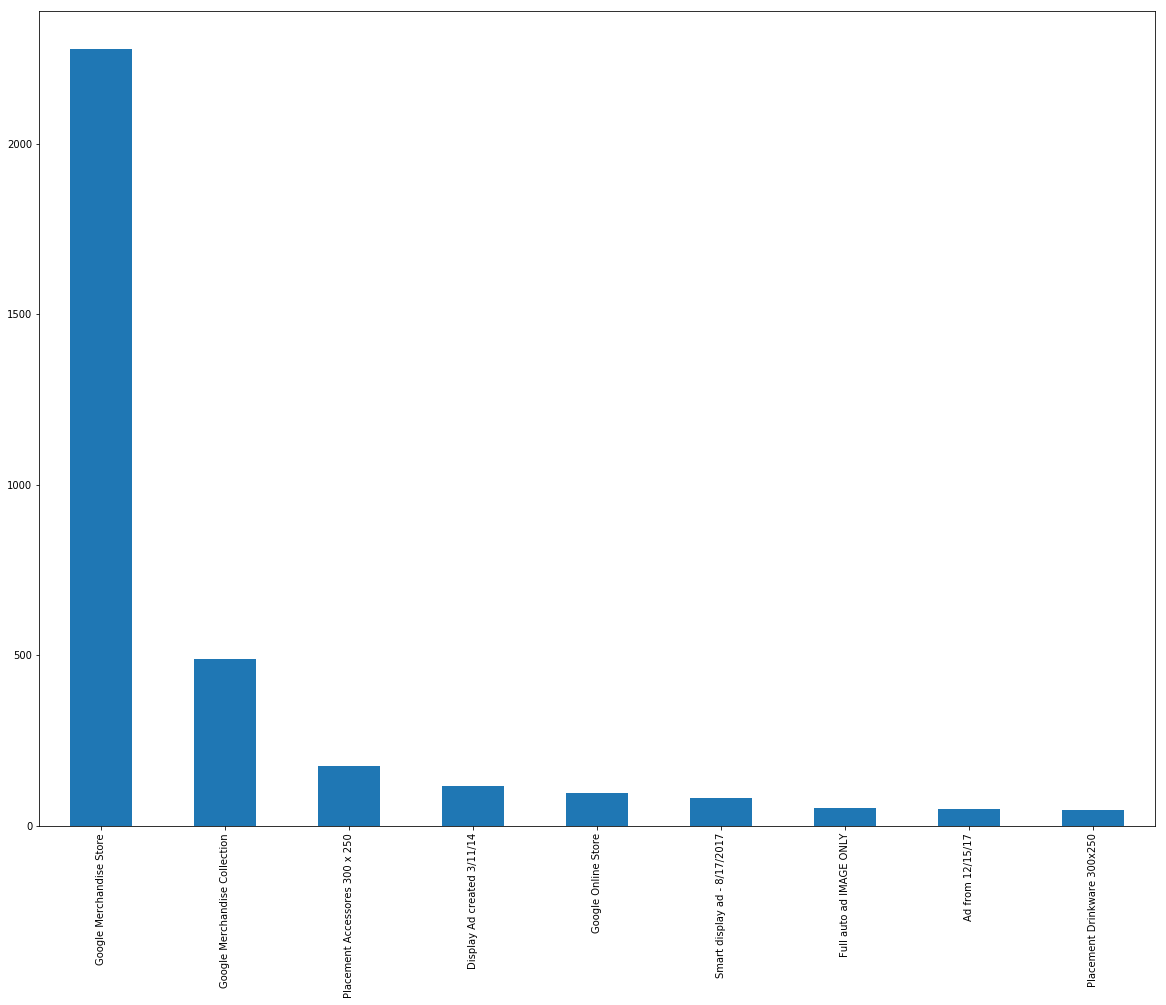

In [11]:
train_df.trafficSource_adContent.value_counts(dropna=False)[1:10].plot.bar(figsize=(20,15))